
Simulating pseudo-longitudinal trajectories...

Most frequent state trajectories:
1. (0, 0, 0, 0) (frequency: 106)
2. (0, 0, 0, 1) (frequency: 21)
3. (0, 1, 0, 0) (frequency: 21)
4. (0, 0, 1, 0) (frequency: 17)
5. (1, 0, 0, 0) (frequency: 10)


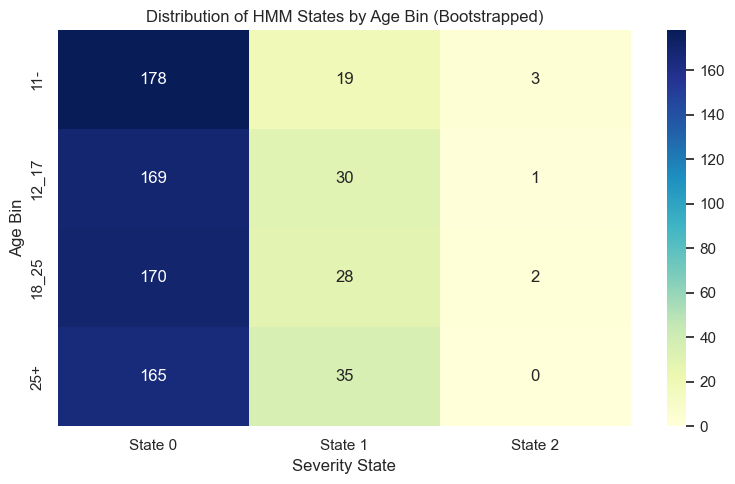

In [2]:
import os
import glob
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings("ignore")

# Plotting style
sns.set_theme(style='whitegrid')

# ===========================
# Load and clean the data
# ===========================

base_dir = "analysis/abide"
selected_rois = [
    # 'Temporal Region',
    'Prefrontal Cortex',
    'Cingulate Cortex',
    'Amygdala',
    'Hippocampus',
    # 'Insula',
    'Cerebellum'
]

def load_and_filter_data(files, group_name, selected_rois=None):
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        df['source_file'] = file
        df['group'] = group_name
        if selected_rois is not None:
            df = df[df['Region'].isin(selected_rois)]
        df_list.append(df)
    return pd.concat(df_list, ignore_index=True)

asd_files = glob.glob(os.path.join(base_dir, "*", "patient", "metrics", "abide_roi_metrics.csv"))
asd_data = load_and_filter_data(asd_files, 'ASD', selected_rois)

control_files = glob.glob(os.path.join(base_dir, "*", "control", "metrics", "abide_roi_metrics.csv"))
control_data = load_and_filter_data(control_files, 'Control', selected_rois)

all_data = pd.concat([asd_data, control_data], ignore_index=True)

# Rename columns for consistency
all_data.rename(columns={
    'SubjectID': 'subject_id',
    'Sex': 'sex',
    'Age': 'age',
    'Region': 'ROI',
    'Closeness': 'metric1',
    'Clustering': 'metric2',
    'Degree': 'metric3'
}, inplace=True)

all_data.dropna(inplace=True)

# Extract age bin from file path
def extract_age_bin(path):
    match = re.search(r"abide[\\/](.*?)[\\/]", path)
    return match.group(1) if match else "unknown"

all_data['age_bin'] = all_data['source_file'].apply(extract_age_bin)
age_bin_order = ["11-", "12_17", "18_25", "25+"]
all_data['age_bin'] = pd.Categorical(all_data['age_bin'], categories=age_bin_order, ordered=True)

# Pivot data by subject
def create_pivot(df):
    subject_ages = df.groupby('subject_id')['age'].first()
    subject_bins = df.groupby('subject_id')['age_bin'].first()
    pivot_df = df.pivot_table(index='subject_id', columns='ROI', values=['metric1', 'metric2', 'metric3'])
    pivot_df.columns = [f'{metric}_{roi}' for metric, roi in pivot_df.columns]
    pivot_df.reset_index(inplace=True)
    pivot_df['age'] = pivot_df['subject_id'].map(subject_ages)
    pivot_df['age_bin'] = pivot_df['subject_id'].map(subject_bins)
    return pivot_df

asd_pivot_df = create_pivot(all_data[all_data['group'] == 'ASD']).dropna()
asd_pivot_df['group'] = 'ASD'

control_pivot_df = create_pivot(all_data[all_data['group'] == 'Control']).dropna()
control_pivot_df['group'] = 'Control'

# ===========================
# HMM for ASD patients
# ===========================

roi_columns_asd = [col for col in asd_pivot_df.columns if 'metric' in col]
X_asd = asd_pivot_df[roi_columns_asd].values

# Remove zero-variance features
variances = X_asd.var(axis=0)
X_asd = X_asd[:, variances > 0]
roi_columns_asd = [col for i, col in enumerate(roi_columns_asd) if variances[i] > 0]

# Scale data
scaler_asd = StandardScaler()
X_asd_scaled = scaler_asd.fit_transform(X_asd)

# Fit HMM with multiple seeds
best_model_asd = None
best_score = -np.inf
n_states = 3

for seed in range(10):
    try:
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=300, random_state=seed)
        model.fit(X_asd_scaled)
        score = model.score(X_asd_scaled)
        if not np.isnan(score) and score > best_score:
            best_model_asd = model
            best_score = score
    except Exception as e:
        print(f"HMM error for seed {seed}: {e}")

if best_model_asd is not None:
    hidden_states_asd = best_model_asd.predict(X_asd_scaled)
    asd_pivot_df['ASD_severity_state'] = hidden_states_asd
else:
    print("No valid HMM model found for ASD patients.")

# ===========================
# Pseudo-longitudinal analysis via bootstrapping
# ===========================

N_BOOTSTRAPS = 200
age_bins = age_bin_order
state_trajectories = []

print("\nSimulating pseudo-longitudinal trajectories...")

for b in range(N_BOOTSTRAPS):
    trajectory = []
    valid = True
    for bin_label in age_bins:
        candidates = asd_pivot_df[asd_pivot_df['age_bin'] == bin_label]
        if candidates.empty:
            valid = False
            break
        chosen = candidates.sample(n=1, random_state=b)
        features = chosen[roi_columns_asd].values
        features_scaled = scaler_asd.transform(features)
        state = best_model_asd.predict(features_scaled)[0]
        trajectory.append(state)
    if valid:
        state_trajectories.append(tuple(trajectory))

# Show most frequent trajectories
trajectory_counts = Counter(state_trajectories)
most_common = trajectory_counts.most_common(5)

print("\nMost frequent state trajectories:")
for i, (traj, count) in enumerate(most_common):
    print(f"{i+1}. {traj} (frequency: {count})")

# Aggregated heatmap
state_counts_per_bin = {bin_label: [0]*n_states for bin_label in age_bins}
for traj in state_trajectories:
    for i, state in enumerate(traj):
        state_counts_per_bin[age_bins[i]][state] += 1

df_heat = pd.DataFrame(state_counts_per_bin).T
df_heat.columns = [f'State {i}' for i in range(n_states)]

plt.figure(figsize=(8, 5))
sns.heatmap(df_heat, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Distribution of HMM States by Age Bin (Bootstrapped)")
plt.xlabel("Severity State")
plt.ylabel("Age Bin")
plt.tight_layout()
plt.show()
